# Load and visualize texutres

In [1]:
%pip install matplotlib opencv-python

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import time

In [2]:
dirt_texture: np.array = cv.imread("assets/dirt.png")
stone_texture: np.array = cv.imread("assets/stone.png")
diamond_texture: np.array = cv.imread("assets/diamond.png")

dirt_texture = cv.cvtColor(dirt_texture, cv.COLOR_BGR2RGB)
stone_texture = cv.cvtColor(stone_texture, cv.COLOR_BGR2RGB)
diamond_texture = cv.cvtColor(diamond_texture, cv.COLOR_BGR2RGB)

Text(0.5, 1.0, 'Diamond Texture')

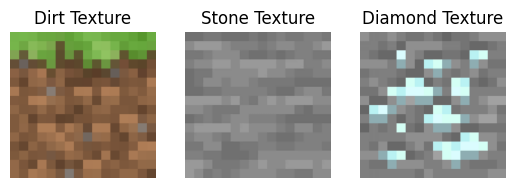

In [3]:
plt.subplot(1, 3, 1) 
plt.imshow(dirt_texture)  
plt.axis('off')  
plt.title("Dirt Texture") 

plt.subplot(1, 3, 2) 
plt.imshow(stone_texture)  
plt.axis('off')  
plt.title("Stone Texture") 

plt.subplot(1, 3, 3) 
plt.imshow(diamond_texture)  
plt.axis('off')  
plt.title("Diamond Texture") 

# Wasserstein Distance

## Sliced Quadratic Wasserstein Distance

In [4]:
def sliced_wasserstein_2(X: np.array, Y: np.array, K: int = 64) -> float:
    _, d = X.shape
    accum: float = 0
    
    for _ in range(K):
        v: np.array = np.random.normal(0, 1, d) # d refers to the dimension of elements in our pointclouds (x, y, r, g, b)

        theta: np.array = np.zeros_like(v)
        if np.linalg.norm(v) != 0 : theta = v / np.linalg.norm(v)  

        X_proj: np.array = X.dot(theta)
        Y_proj: np.array = Y.dot(theta)

        X_proj, Y_proj = np.sort(X_proj), np.sort(Y_proj)

        w_2 = np.mean((X_proj - Y_proj)**2)

        accum += w_2
    
    return accum / K

In [5]:
# This should yeild 1.0 since the distributions have uniform spacing
X = np.array([[0], [0.5], [1]])
Y = np.array([[1], [1.5], [2]])

dist = sliced_wasserstein_2(X, Y, 10)
print(dist)  # should be 1

1.0


## Sliced Quadratic Wasserstein Barycenter

In [6]:
def sliced_wasserstein_2_barycenter(Y_list: list[np.ndarray], rhos: np.ndarray, K: int = 32, step_size: float = 1.0, n_iter: int = 100) -> np.ndarray:
    J = len(Y_list)
    n, d = Y_list[0].shape
    
    # Initialize barycenter with a random sample from Y as suggested by the paper
    idx = np.random.randint(0, n)
    X = Y_list[0][idx:idx+1].copy()
    X = np.tile(X, (n, 1)).astype(np.float64)

    for _ in range(n_iter):
        gradient = np.zeros((n, d))
        H = np.zeros((d, d))

        for _ in range(K):
            v = np.random.normal(0, 1, d)
            if np.linalg.norm(v) == 0:
                continue
            theta = v / np.linalg.norm(v)

            X_proj = X.dot(theta)
            sort_idx = np.argsort(X_proj)
            X_proj_sorted = X_proj[sort_idx]

            # Accumulate over all Y_j
            diff_sorted = np.zeros(n)
            for j in range(J):
                Y_proj_j = np.sort(Y_list[j] @ theta)
                diff_sorted += rhos[j] * (X_proj_sorted - Y_proj_j)

            diff = np.zeros(n)
            diff[sort_idx] = diff_sorted
            gradient += np.outer(diff, theta)

            H += np.outer(theta, theta)

        gradient /= K
        H /= K

        H_pinv = np.linalg.pinv(H)

        X -= step_size * (gradient @ H_pinv)

    return X

In [7]:
def sliced_wasserstein_2_projection(X: np.ndarray,
                                  Y: np.ndarray,
                                  K: int = 32,
                                  step_size: float = 1.0,
                                  n_iter: int = 100) -> np.ndarray:
    n, d = X.shape
    X = X.copy()

    for _ in range(n_iter):
        gradient = np.zeros((n, d))
        H = np.zeros((d, d))

        for _ in range(K):
            v = np.random.normal(0, 1, d)
            if np.linalg.norm(v) == 0:
                continue
            theta = v / np.linalg.norm(v)

            X_proj = X.dot(theta)
            sort_idx = np.argsort(X_proj)
            X_proj_sorted = X_proj[sort_idx]

            Y_proj = np.sort(Y.dot(theta))
            diff_sorted = X_proj_sorted - Y_proj

            diff = np.zeros(n)
            diff[sort_idx] = diff_sorted

            gradient += np.outer(diff, theta)
            H += np.outer(theta, theta)

        gradient /= K
        H /= K

        H_pinv = np.linalg.pinv(H)

        X -= step_size * (gradient @ H_pinv)

    return X

In [8]:
Y1 = np.array([[0], [1], [2]])
Y2 = np.array([[1], [1], [1]])
Y_list = [Y1, Y2]
rhos = np.array([0.5, 0.5])

X_bar = sliced_wasserstein_2_barycenter(Y_list, rhos, K=16, step_size=0.5, n_iter=1000)
X_bar

array([[0.5],
       [1. ],
       [1.5]])

In [9]:
X = np.array([[0], [0.5], [1]])
Y = np.array([[1], [1.5], [2]])

X_proj = sliced_wasserstein_2_projection(X, Y, K=16, step_size=0.5, n_iter=100)
X_proj

array([[1. ],
       [1.5],
       [2. ]])

# Texture Synthesis

In [41]:
!pip install pyrtools


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## First Order Statistical Mixing

In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pyrtools as pt
import scipy.signal as sps
import cv2

In [ ]:
def first_order_texture_mixing(textures: list[np.ndarray], 
                               rhos: np.ndarray,
                               height: int = 4,
                               order: int = 3,
                               n_iter: int = 6,
                               K: int = 32,
                               step_size: float = 0.4,
                               barycenter_iter: int = 40,
                               proj_iter: int = 8,
                               verbose: bool = True) -> np.ndarray:
    J = len(textures)
    
    # Ensure textures are float and normalized to [0, 1]
    textures = [tex.astype(np.float64) / 255.0 if tex.max() > 1 else tex.astype(np.float64) 
                for tex in textures]
    
    # Get output size from first texture
    P, Q, _ = textures[0].shape
    
    if verbose:
        print(f"Computing steerable pyramids for {J} textures of size {P}x{Q}...")
        start_time = time.time()
    
    # Build steerable pyramids for each texture (separate per channel)
    pyramids = []
    for j, tex in enumerate(textures):
        # Process each color channel separately
        pyr_channels = []
        for c in range(3):
            pyr_c = pt.pyramids.SteerablePyramidFreq(tex[:, :, c], height=height, order=order-1, is_complex=False)
            pyr_channels.append(pyr_c)
        pyramids.append(pyr_channels)
    
    # Extract all coefficient distributions Y_{ℓ,j} for each scale/orientation ℓ and texture j
    # Get the keys (scale/orientation indices) from first pyramid, first channel
    pyr_keys = list(pyramids[0][0].pyr_coeffs.keys())
    
    if verbose:
        print(f"  Pyramid decomposition complete ({time.time() - start_time:.2f}s)")
        print(f"  {len(pyr_keys)} subbands")
        print("\nComputing coefficient barycenters...")
        start_time = time.time()
    
    # Compute barycentric distributions Y_ℓ for each scale/orientation
    Y_ell = {}
    for l_idx, key in enumerate(pyr_keys):
        # Collect distributions Y_{ℓ,j} for all textures at this scale/orientation
        Y_list = []
        for j in range(J):
            # Stack coefficients from all 3 color channels at corresponding positions
            # Each coefficient location gives us a 3D vector [R_coeff, G_coeff, B_coeff]
            coeffs_rgb = []
            for c in range(3):
                coeff = pyramids[j][c].pyr_coeffs[key]
                coeffs_rgb.append(coeff.flatten())
            
            # Shape: (n_points, 3) where each row is [R, G, B] coefficients at same location
            coeff_flat = np.stack(coeffs_rgb, axis=1)
            Y_list.append(coeff_flat)
        
        # Compute barycenter in 3D coefficient space
        Y_ell[key] = sliced_wasserstein_2_barycenter(
            Y_list, rhos, K=K, step_size=step_size, n_iter=barycenter_iter
        )
        
        if verbose and (l_idx + 1) % 5 == 0:
            print(f"  Processed {l_idx + 1}/{len(pyr_keys)} subbands")
    
    if verbose:
        print(f"  Coefficient barycenters complete ({time.time() - start_time:.2f}s)")
        print("\nComputing pixel barycenter...")
        start_time = time.time()
    
    # Compute barycenter of pixel distributions
    pixel_Y_list = []
    for tex in textures:
        # Each pixel is a 3D vector [R, G, B]
        pixel_Y_list.append(tex.reshape(-1, 3))
    
    Y_pixels = sliced_wasserstein_2_barycenter(
        pixel_Y_list, rhos, K=K, step_size=step_size, n_iter=barycenter_iter
    )
    
    if verbose:
        print(f"  Pixel barycenter complete ({time.time() - start_time:.2f}s)")
        print(f"\nStarting iterative synthesis ({n_iter} iterations)...")
    
    # Initialize synthesis with white noise
    f_k = np.random.randn(P, Q, 3).astype(np.float64) * 0.2 + 0.5
    f_k = np.clip(f_k, 0, 1)
    
    # Iterative synthesis
    for k in range(n_iter):
        iter_start = time.time()
        
        # Build pyramid of current image (separate per channel)
        pyr_k_channels = []
        for c in range(3):
            pyr_k_c = pt.pyramids.SteerablePyramidFreq(f_k[:, :, c], height=height, order=order-1, is_complex=False)
            pyr_k_channels.append(pyr_k_c)
        
        # Project coefficients onto barycentric distributions
        c_k_channels = [{} for _ in range(3)]
        for key in pyr_keys:
            # Stack coefficients from all 3 channels
            coeffs_rgb = []
            original_shape = None
            for c in range(3):
                coeff = pyr_k_channels[c].pyr_coeffs[key]
                if original_shape is None:
                    original_shape = coeff.shape
                coeffs_rgb.append(coeff.flatten())
            
            # Shape: (n_points, 3)
            coeff_flat = np.stack(coeffs_rgb, axis=1)
            
            # Project onto barycentric distribution
            coeff_proj = sliced_wasserstein_2_projection(
                coeff_flat, Y_ell[key], K=K, step_size=step_size, n_iter=proj_iter
            )
            
            # Split back to separate channels and reshape
            for c in range(3):
                c_k_channels[c][key] = coeff_proj[:, c].reshape(original_shape)
        
        # Reconstruct image from projected coefficients (per channel)
        f_tilde_k_channels = []
        for c in range(3):
            pyr_k_channels[c].pyr_coeffs = c_k_channels[c]
            recon_c = pyr_k_channels[c].recon_pyr()
            f_tilde_k_channels.append(recon_c)
        
        f_tilde_k = np.stack(f_tilde_k_channels, axis=-1)  # Stack to (H, W, 3)
        
        # Project pixel values onto barycentric pixel distribution
        pixels_flat = f_tilde_k.reshape(-1, 3)
        pixels_proj = sliced_wasserstein_2_projection(
            pixels_flat, Y_pixels, K=K, step_size=step_size, n_iter=proj_iter
        )
        f_k = pixels_proj.reshape(P, Q, 3)
        
        # Clip to valid range
        f_k = np.clip(f_k, 0, 1)
        
        if verbose:
            print(f"  Iteration {k+1}/{n_iter} complete ({time.time() - iter_start:.2f}s)")
    
    if verbose:
        print("\nSynthesis complete!")
    
    # Convert back to [0, 255] uint8
    result = (f_k * 255).astype(np.uint8)
    
    return result

Starting first-order synthesis with GPU acceleration...
Input size: (256, 256, 3)
Computing steerable pyramids for 2 textures of size 256x256...
  Pyramid decomposition complete (0.15s)
  11 subbands

Computing coefficient barycenters...
  Processed 5/11 subbands
  Processed 5/11 subbands
  Processed 10/11 subbands
  Processed 10/11 subbands
  Coefficient barycenters complete (114.48s)

Computing pixel barycenter...
  Coefficient barycenters complete (114.48s)

Computing pixel barycenter...
  Pixel barycenter complete (82.88s)

Starting iterative synthesis (5 iterations)...
  Pixel barycenter complete (82.88s)

Starting iterative synthesis (5 iterations)...
  Iteration 1/5 complete (128.51s)
  Iteration 1/5 complete (128.51s)
  Iteration 2/5 complete (92.64s)
  Iteration 2/5 complete (92.64s)
  Iteration 3/5 complete (87.07s)
  Iteration 3/5 complete (87.07s)
  Iteration 4/5 complete (90.86s)
  Iteration 4/5 complete (90.86s)
  Iteration 5/5 complete (81.65s)

Synthesis complete!

Tota

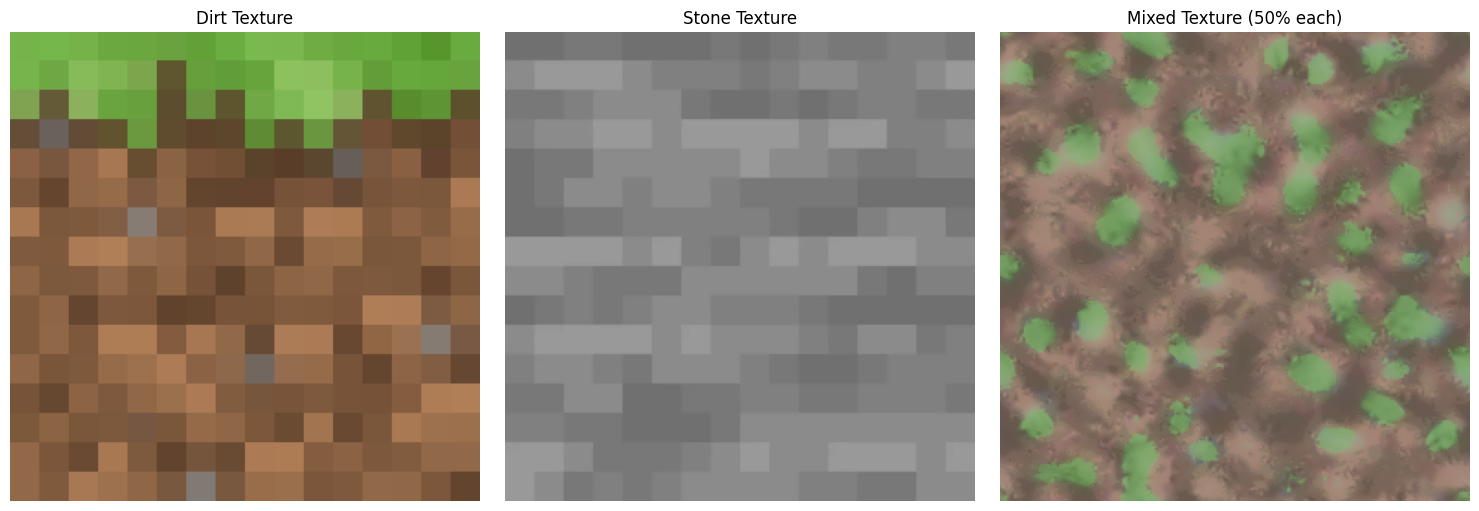

In [12]:
dirt = cv2.imread("assets/dirt.png")
stone = cv2.imread("assets/stone.png")

dirt = cv2.cvtColor(dirt, cv2.COLOR_BGR2RGB)
stone = cv2.cvtColor(stone, cv2.COLOR_BGR2RGB)

# Downscale textures for faster computations
target_size = 256  # small test size
dirt_small = cv2.resize(dirt, (target_size, target_size), interpolation=cv2.INTER_AREA)
stone_small = cv2.resize(stone, (target_size, target_size), interpolation=cv2.INTER_AREA)

textures = [dirt_small, stone_small]
rhos = np.array([0.5, 0.5])

print("Starting first-order synthesis with GPU acceleration...")
print(f"Input size: {dirt_small.shape}")

total_start = time.time()
synthesized = first_order_texture_mixing(
    textures, rhos,
    height=3,
    order=3,
    n_iter=5,
    K=64,
    step_size=0.1,
    barycenter_iter=50,
    proj_iter=50,
    verbose=True
)
total_time = time.time() - total_start

print(f"\n{'='*60}")
print(f"Total synthesis time: {total_time:.2f} seconds")
print(f"{'='*60}")
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(dirt_small)
axes[0].set_title("Dirt Texture")
axes[0].axis('off')

axes[1].imshow(stone_small)
axes[1].set_title("Stone Texture")
axes[1].axis('off')

axes[2].imshow(synthesized)
axes[2].set_title("Mixed Texture (50% each)")
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
output_dir = "output/first_order"
os.makedirs(output_dir, exist_ok=True)

# Load textures
dirt = cv2.imread("assets/diamond.png")
stone = cv2.imread("assets/stone.png")

dirt = cv2.cvtColor(dirt, cv2.COLOR_BGR2RGB)
stone = cv2.cvtColor(stone, cv2.COLOR_BGR2RGB)

# Downscale textures for faster computation
target_size = 64
dirt_small = cv2.resize(dirt, (target_size, target_size), interpolation=cv2.INTER_AREA)
stone_small = cv2.resize(stone, (target_size, target_size), interpolation=cv2.INTER_AREA)

# Save the target textures
cv2.imwrite(os.path.join(output_dir, "dirt.png"), cv2.cvtColor(dirt_small, cv2.COLOR_RGB2BGR))
cv2.imwrite(os.path.join(output_dir, "stone.png"), cv2.cvtColor(stone_small, cv2.COLOR_RGB2BGR))

textures = [dirt_small, stone_small]

# Rho values from 0.1 to 1.0
rhos_list = np.arange(0.1, 1.1, 0.1)

# Prepare a figure to plot all transformations
fig, axes = plt.subplots(1, len(rhos_list), figsize=(5 * len(rhos_list), 5))

for i, rho in enumerate(rhos_list):
    rhos = np.array([rho, 1 - rho])
    
    # Generate mixed texture
    synthesized = first_order_texture_mixing(
        textures, rhos,
        height=2,
        order=3,
        n_iter=5,
        K=64,
        step_size=0.1,
        barycenter_iter=200,
        proj_iter=200,
        verbose=False
    )
    
    # Save each synthesized texture
    cv2.imwrite(os.path.join(output_dir, f"synthesized_rho_{rho:.1f}.png"),
                cv2.cvtColor(synthesized, cv2.COLOR_RGB2BGR))
    
    # Plot
    axes[i].imshow(synthesized)
    axes[i].set_title(f"Rho = {rho:.1f}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Higher-order statistical mixing

In [ ]:
def higher_order_texture_mixing(textures: list[np.ndarray], 
                                rhos: np.ndarray,
                                height: int = 4,
                                order: int = 3,
                                n_iter: int = 6,
                                K: int = 32,
                                step_size: float = 0.4,
                                barycenter_iter: int = 40,
                                proj_iter: int = 8,
                                block_size: int = 4,
                                verbose: bool = True) -> np.ndarray:
    J = len(textures)
    
    # Ensure textures are float and normalized to [0, 1]
    textures = [tex.astype(np.float64) / 255.0 if tex.max() > 1 else tex.astype(np.float64) 
                for tex in textures]
    
    # Get output size from first texture
    P, Q, _ = textures[0].shape
    
    if verbose:
        print(f"Computing steerable pyramids for {J} textures of size {P}x{Q}...")
        start_time = time.time()
    
    # Build steerable pyramids for each texture (separate per channel)
    pyramids = []
    for j, tex in enumerate(textures):
        pyr_channels = []
        for c in range(3):
            pyr_c = pt.pyramids.SteerablePyramidFreq(tex[:, :, c], height=height, order=order-1, is_complex=False)
            pyr_channels.append(pyr_c)
        pyramids.append(pyr_channels)
    
    pyr_keys = list(pyramids[0][0].pyr_coeffs.keys())
    
    if verbose:
        print(f"  Pyramid decomposition complete ({time.time() - start_time:.2f}s)")
        print(f"  {len(pyr_keys)} subbands")
        print(f"\nComputing joint distribution barycenters (block_size={block_size}x{block_size})...")
        start_time = time.time()
    
    # Compute barycentric joint distributions C_ℓ for each scale/orientation
    C_ell = {}
    coeff_shapes = {}
    
    for l_idx, key in enumerate(pyr_keys):
        coeff_shape = pyramids[0][0].pyr_coeffs[key].shape
        coeff_shapes[key] = coeff_shape
        h, w = coeff_shape
        
        # Collect joint distributions C_{ℓ,j} for all textures
        C_list = []
        
        for j in range(J):
            # Get coefficients for all 3 channels
            coeffs_rgb = []
            for c in range(3):
                coeff = pyramids[j][c].pyr_coeffs[key]
                coeffs_rgb.append(coeff)
            
            # Extract blocks: for each position n, get neighborhood N(n)
            blocks = []
            
            # Slide a block_size x block_size window over the coefficient map
            for i in range(0, h - block_size + 1, 1):  # stride=1 for overlapping blocks
                for k in range(0, w - block_size + 1, 1):
                    # Extract block of size block_size x block_size from each channel
                    block_features = []
                    for c in range(3):
                        block = coeffs_rgb[c][i:i+block_size, k:k+block_size]
                        block_features.append(block.flatten())
                    
                    # Concatenate RGB blocks: shape (3 * block_size^2,)
                    block_vec = np.concatenate(block_features)
                    blocks.append(block_vec)
            
            # Shape: (n_blocks, 3 * block_size^2)
            C_j = np.array(blocks)
            C_list.append(C_j)
        
        # Compute barycenter of joint distributions
        if len(C_list[0]) > 0:  # Check if we have blocks
            C_ell[key] = sliced_wasserstein_2_barycenter(
                C_list, rhos, K=K, step_size=step_size, n_iter=barycenter_iter
            )
        
        if verbose and (l_idx + 1) % 5 == 0:
            print(f"  Processed {l_idx + 1}/{len(pyr_keys)} subbands")
    
    if verbose:
        print(f"  Joint barycenters complete ({time.time() - start_time:.2f}s)")
        print("\nComputing pixel barycenter...")
        start_time = time.time()
    
    # Compute barycenter of pixel distributions
    pixel_Y_list = [tex.reshape(-1, 3) for tex in textures]
    Y_pixels = sliced_wasserstein_2_barycenter(
        pixel_Y_list, rhos, K=K, step_size=step_size, n_iter=barycenter_iter
    )
    
    if verbose:
        print(f"  Pixel barycenter complete ({time.time() - start_time:.2f}s)")
        print(f"\nStarting iterative synthesis ({n_iter} iterations)...")
    
    # Initialize synthesis with white noise
    f_k = np.random.randn(P, Q, 3).astype(np.float64) * 0.2 + 0.5
    f_k = np.clip(f_k, 0, 1)
    
    # Iterative synthesis
    for k in range(n_iter):
        iter_start = time.time()
        
        # Build pyramid of current image
        pyr_k_channels = []
        for c in range(3):
            pyr_k_c = pt.pyramids.SteerablePyramidFreq(f_k[:, :, c], height=height, order=order-1, is_complex=False)
            pyr_k_channels.append(pyr_k_c)
        
        # Project using joint distributions
        c_k_channels = [{} for _ in range(3)]
        
        for key in pyr_keys:
            h, w = coeff_shapes[key]
            
            # Get current coefficients
            coeffs_k_rgb = []
            for c in range(3):
                coeffs_k_rgb.append(pyr_k_channels[c].pyr_coeffs[key].copy())
            
            # Extract blocks from current coefficients
            blocks_k = []
            block_positions = []
            
            for i in range(0, h - block_size + 1, 1):
                for j in range(0, w - block_size + 1, 1):
                    block_features = []
                    for c in range(3):
                        block = coeffs_k_rgb[c][i:i+block_size, j:j+block_size]
                        block_features.append(block.flatten())
                    
                    block_vec = np.concatenate(block_features)
                    blocks_k.append(block_vec)
                    block_positions.append((i, j))
            
            if len(blocks_k) == 0:
                # If no blocks (subband too small), skip
                for c in range(3):
                    c_k_channels[c][key] = coeffs_k_rgb[c]
                continue
            
            # Project blocks onto joint barycentric distribution
            blocks_k_array = np.array(blocks_k)
            blocks_proj = sliced_wasserstein_2_projection(
                blocks_k_array, C_ell[key], K=K, step_size=step_size, n_iter=proj_iter
            )
            
            # Reconstruct coefficients from projected blocks using averaging
            # Initialize output with zeros and count overlaps
            coeffs_proj_rgb = [np.zeros((h, w)) for _ in range(3)]
            overlap_count = np.zeros((h, w))
            
            for idx, (i, j) in enumerate(block_positions):
                block_vec = blocks_proj[idx]
                
                # Split block_vec back into RGB channels
                block_len = block_size * block_size
                for c in range(3):
                    block_c = block_vec[c * block_len:(c + 1) * block_len]
                    block_2d = block_c.reshape(block_size, block_size)
                    coeffs_proj_rgb[c][i:i+block_size, j:j+block_size] += block_2d
                
                overlap_count[i:i+block_size, j:j+block_size] += 1
            
            # Average overlapping regions
            for c in range(3):
                coeffs_proj_rgb[c] = np.divide(
                    coeffs_proj_rgb[c], 
                    overlap_count, 
                    out=np.zeros_like(coeffs_proj_rgb[c]), 
                    where=overlap_count != 0
                )
                c_k_channels[c][key] = coeffs_proj_rgb[c]
        
        # Reconstruct image from projected coefficients
        f_tilde_k_channels = []
        for c in range(3):
            pyr_k_channels[c].pyr_coeffs = c_k_channels[c]
            recon_c = pyr_k_channels[c].recon_pyr()
            f_tilde_k_channels.append(recon_c)
        
        f_tilde_k = np.stack(f_tilde_k_channels, axis=-1)
        
        # Project pixel values onto barycentric pixel distribution
        pixels_flat = f_tilde_k.reshape(-1, 3)
        pixels_proj = sliced_wasserstein_2_projection(
            pixels_flat, Y_pixels, K=K, step_size=step_size, n_iter=proj_iter
        )
        f_k = pixels_proj.reshape(P, Q, 3)
        
        # Clip to valid range
        f_k = np.clip(f_k, 0, 1)
        
        if verbose:
            print(f"  Iteration {k+1}/{n_iter} complete ({time.time() - iter_start:.2f}s)")
    
    if verbose:
        print("\nSynthesis complete!")
    
    # Convert back to [0, 255] uint8
    result = (f_k * 255).astype(np.uint8)
    
    return result

Computing steerable pyramid decompositions for 2 textures...
  Texture 1: (64, 64, 3), pyramid levels: 8
  Texture 2: (64, 64, 3), pyramid levels: 8
Pyramid has 8 subbands
Computing joint distribution barycenters (block_size=4x4)...
  Computed joint barycenter for 5/8 subbands
Computing pixel value barycenter...
Starting iterative synthesis (5 iterations)...
  Iteration 1/5 complete
  Iteration 2/5 complete
  Iteration 3/5 complete
  Iteration 4/5 complete
  Iteration 5/5 complete


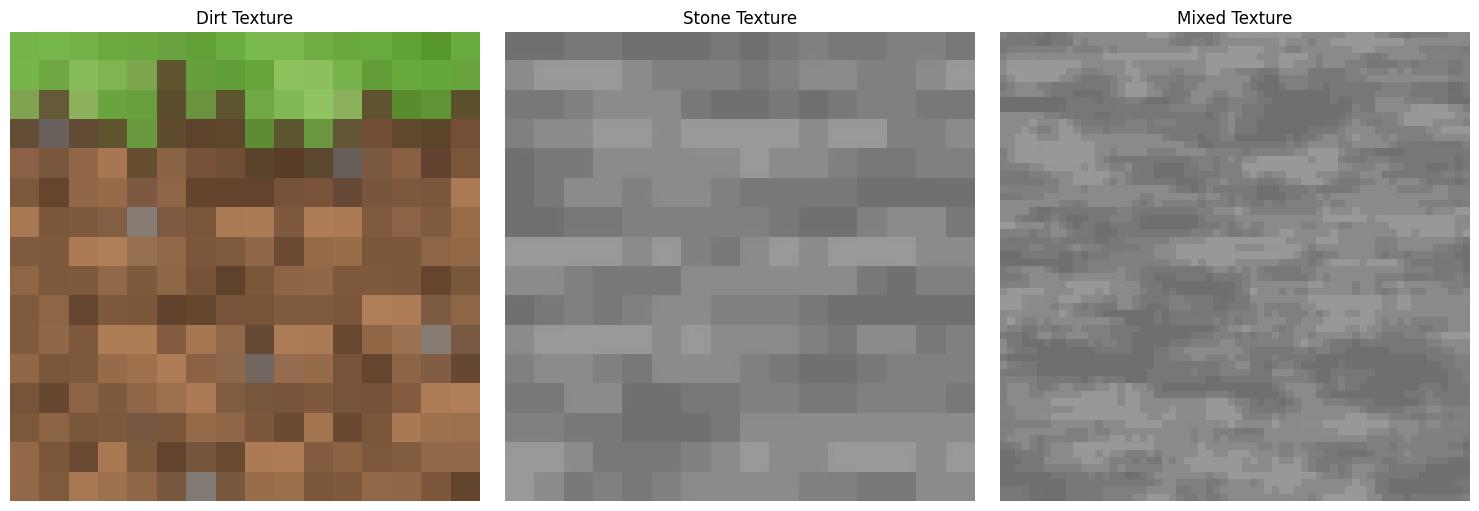

In [47]:
dirt = cv2.imread("assets/dirt.png")
stone = cv2.imread("assets/stone.png")

dirt = cv2.cvtColor(dirt, cv2.COLOR_BGR2RGB)
stone = cv2.cvtColor(stone, cv2.COLOR_BGR2RGB)

# Downscale textures for faster computations
target_size = 64  # small test size
dirt_small = cv2.resize(dirt, (target_size, target_size), interpolation=cv2.INTER_AREA)
stone_small = cv2.resize(stone, (target_size, target_size), interpolation=cv2.INTER_AREA)

textures = [dirt_small, stone_small]
rhos = np.array([0.0, 1.0])

synthesized = higher_order_texture_mixing(
    textures, rhos,
    height=2,      
    order=3,       
    n_iter=5,    
    K=64,          
    step_size=0.1,
    barycenter_iter=200, 
    proj_iter=200,
    block_size=4,        # Joint distribution neighborhood size
    verbose=True
)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(dirt_small)
axes[0].set_title("Dirt Texture")
axes[0].axis('off')

axes[1].imshow(stone_small)
axes[1].set_title("Stone Texture")
axes[1].axis('off')

axes[2].imshow(synthesized)
axes[2].set_title("Mixed Texture")
axes[2].axis('off')

plt.tight_layout()
plt.show()